In [1]:
!pip install ultralytics

Active code page: 65001


In [3]:
import json
import os
import pandas as pd
import numpy as np
from PIL import Image
# from google.colab import drive
from ultralytics import YOLO
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

In [4]:
only_robo_df = pd.read_pickle('../data/only_robo_df.pkl')

In [10]:
only_robo_df

,id,name,new_ingredients,minutes,steps,description,vege/vegan,food type,healthiness,new_ingredients_idx
0,23933,chinese candy,"[butter, salt, noodle]",15,['melt butterscotch chips in heavy saucepan ov...,"a little different, and oh so good. i include ...",non-vegan,dish,unhealthy,"[12, 71, 54]"
1,111875,the elvis smoothie,"[butter, milk, banana, sugar]",15,"['place all ingredients in blender', 'blend un...","this is a great smoothie, thick and creamy. my...",non-vegan,dish,healthy,"[12, 52, 5, 76]"
2,101115,no name beef recipe loco moco,"[rice, beef, egg, onion]",30,"['cook rice according to package directions', ...",i saw this dish on a tv travel channel. it was...,non-vegan,dish,healthy,"[69, 7, 32, 57]"
3,163238,the creamed dried beef chipped beef recipe,"[beef, butter, flour, milk, pepper]",75,"['melt butter in 2 quart sauce pan or larger',...",this is a long-time favorite recipe of our lan...,non-vegan,dish,healthy,"[7, 12, 37, 52, 62]"
4,16327,creamed spinach,"[onion, cheese, yogurt, spinach]",15,['i keep drained yogurt available in my fridge...,i created this recipe one evening when i wante...,non-vegan,dish,unhealthy,"[57, 19, 81, 73]"
...,...,...,...,...,...,...,...,...,...,...
2640,326105,zucchini with bacon corn peppers,"[garlic, onion, cheese, zucchini, bacon, corn,...",45,"['in a wide frying pan , cook your bacon until...",this is a very colorful addition to any meal. ...,non-vegan,dish,unhealthy,"[38, 57, 19, 82, 4, 29, 62]"
2641,54175,zucchini with green peppercorns lemon and par...,"[lemon, salt, cheese, zucchini, oil, pepper]",15,"['whisk together the lemon juice , olive oil ,...",saw this on foodtv's cooking thin show. it is ...,non-vegan,dish,unhealthy,"[47, 71, 19, 82, 56, 62]"
2642,320622,zucchini with jalapeno monterey jack,"[zucchini, flour, pepper]",15,['spread the zucchini in a microwave-safe dish...,simple and yummy!,non-vegan,dish,unhealthy,"[82, 37, 62]"
2643,152200,zucchini with parmesan,"[salt, cheese, zucchini, oil, pepper]",40,['heat oil in a large skillet over medium heat...,"this recipe came from ""eating well"" magazine, ...",non-vegan,dish,unhealthy,"[71, 19, 82, 56, 62]"


In [5]:
model = YOLO('../data/CASE7.pt')

In [6]:
names = model.names

In [7]:
ing2id = {v:k for k, v in names.items()}

----

In [8]:
image_dir = '../data/test2/images/'

In [9]:
one_hot_encodings = list()
ingredients = list()
images = list()
for img_file in tqdm(os.listdir(image_dir)):
    img_path = os.path.join(image_dir,img_file)
    one_hot_encoding = np.zeros(len(names))
    ingreds = list()
    result = model.predict(img_path, verbose=False)
    yhat = result[0].boxes.cls.detach().cpu().numpy()
    for y in yhat:
        ingreds.append(names[y])
        one_hot_encoding[int(y)] = 1
    one_hot_encodings.append(one_hot_encoding)
    ingredients.append(ingreds)
    images.append(Image.open(img_path))
one_hot_encodings = np.asarray(one_hot_encodings)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:43<00:00,  1.05s/it]


In [11]:
key = list()
for ingred in only_robo_df['new_ingredients']:
    one_hot_encoding = np.zeros(len(names))
    for ing in ingred:
        idx = ing2id[ing]
        one_hot_encoding[idx] = 1
    key.append(one_hot_encoding)
key = np.asarray(key)

-----

In [12]:
distance_matrix = pairwise_distances(one_hot_encodings, key, metric='jaccard')

C:\Users\miy\Anaconda3\envs\ds_study\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [15]:
idx = 10

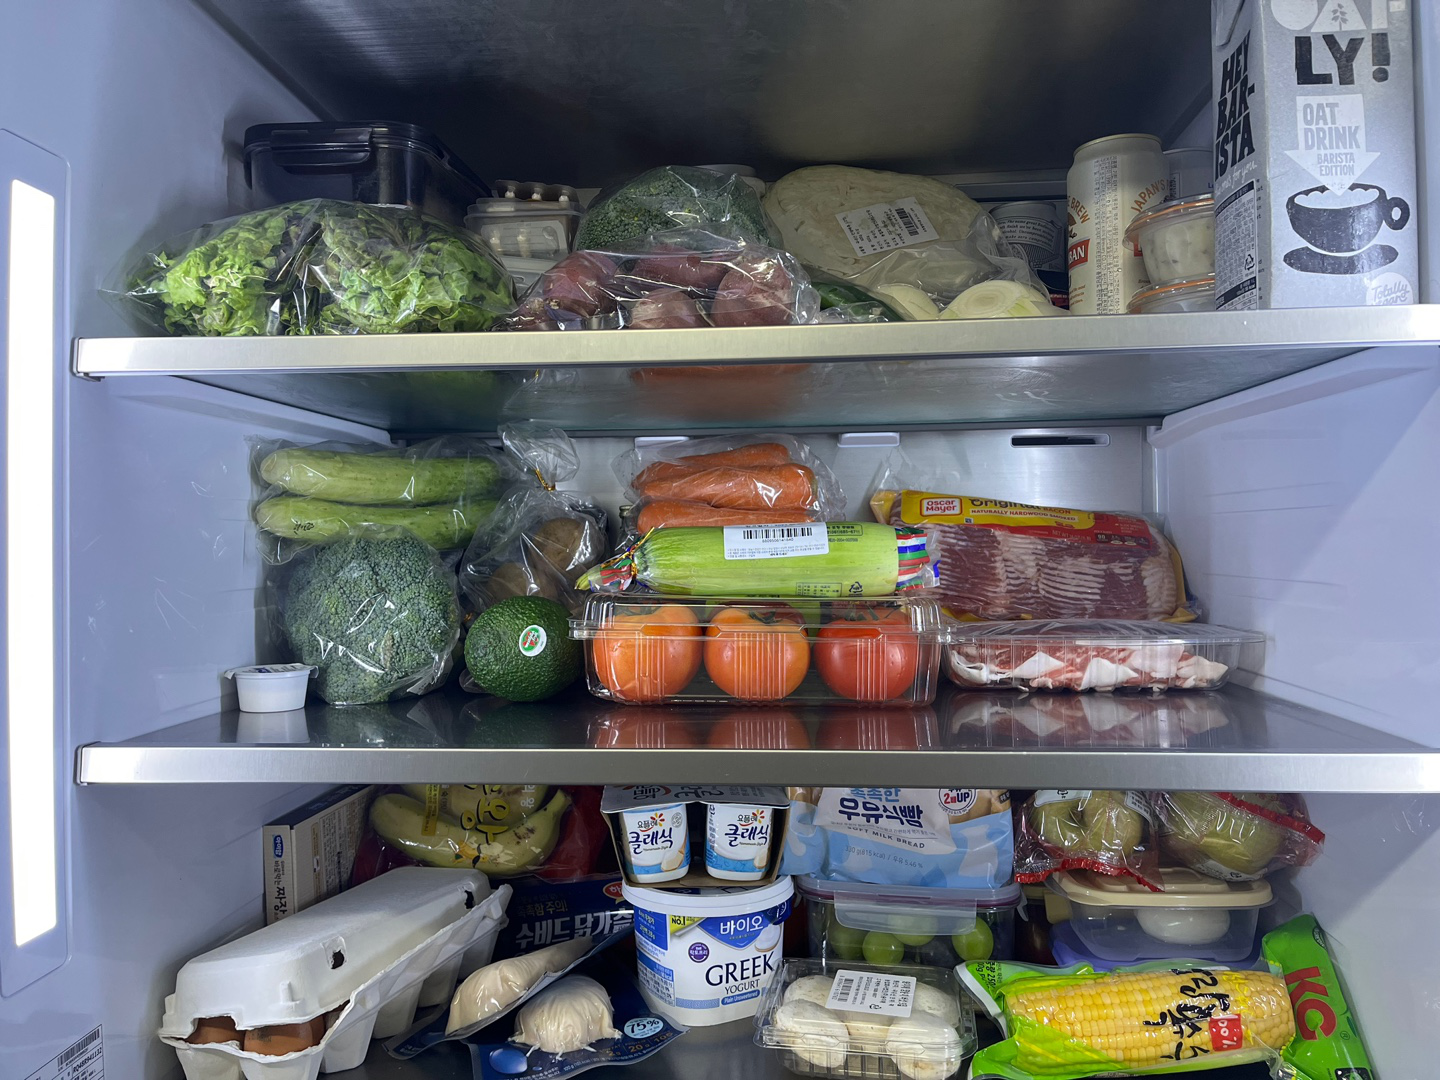

In [16]:
image = images[idx]
image

In [17]:
# Yolo로 예측한 재료
ingreds = ingredients[idx]
print(ingreds)

['yogurt', 'cream', 'cream', 'yogurt', 'yogurt', 'yogurt', 'yogurt', 'yogurt', 'cream', 'yogurt', 'cream', 'cream']


In [18]:
# 가장 유사도가 높은 음식 5개
top_5 = distance_matrix[idx].argsort()[:5]
only_robo_df.iloc[top_5]

,id,name,new_ingredients,minutes,steps,description,vege/vegan,food type,healthiness,new_ingredients_idx
2605,292644,yogurt bavarese,"[sugar, yogurt, cream]",20,['put in a bowl yogurt with the powdered sugar...,easy and delicious :-)!,non-vegan,dish,healthy,"[76, 81, 30]"
1410,140854,lebanese laban yogurt,"[milk, yogurt]",20,['place a couple of tablespoons of the milk in...,plain yogurt,non-vegan,dish,unhealthy,"[52, 81]"
376,291327,butter cream shot,"[butter, cream]",15,['fill glass with cream and pour the schnapps ...,a creamy and super yummy little shot.,non-vegan,dish,unhealthy,"[12, 30]"
1641,33892,no blow torch creme brulee,"[egg, sugar, cream]",30,['beat your egg yolks in a bowl on high until ...,this goes great with a berry-flavored syrup po...,non-vegan,dish,unhealthy,"[32, 76, 30]"
744,297222,custom fruit salad,"[apple, yogurt, banana]",15,"['peel banana and core apple', 'chop both frui...",a 3-ingredient customizable fruit salad everyo...,non-vegan,dish,unhealthy,"[0, 81, 5]"


----

### 임의의 재료로 레시피 추천받기(이미지에서 디텍팅된 클래스 말고 내가 임의로 넣은)

In [19]:
ingreds = ['banana', 'salt', 'avocado']

In [21]:
one_hot_encoding = np.zeros(len(names))
for ingred in ingreds:
    one_hot_encoding[ing2id[ingred]] = 1

In [26]:
distance_matrix = pairwise_distances(one_hot_encoding.reshape(1, -1), key, metric='jaccard')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [27]:
# 가장 유사도가 높은 음식 5개
top_5 = distance_matrix[0].argsort()[:5]
only_robo_df.iloc[top_5]

,id,name,new_ingredients,minutes,steps,description,vege/vegan,food type,healthiness,new_ingredients_numeric
2637,13115,tostones or fried banana venezuela,"[banana, salt, oil]",25,"['peel the banana', 'cut into 2 cm cylinders',...","i always ate this when i was a child, and now ...",non-vegan,dish,unhealthy,"[5, 71, 56]"
2336,372432,simply avocado,"[lime, salt, avocado, oil]",5,"['slice avocado', 'drizzle olive oil over', 's...","extremely simple, elegant and delicious!",non-vegan,dish,unhealthy,"[49, 71, 3, 56]"
942,476024,egg in avocado hole,"[pepper, salt, avocado, egg]",5,['heat a non-stick skillet to medium low heat'...,i saw a picture of this and can't wait for my ...,non-vegan,dish,unhealthy,"[62, 71, 3, 32]"
98,87154,avocado appetiser,"[salt, avocado, egg, onion]",20,"['hard boil eggs', 'chop onion , fine', 'combi...",most fridays i bake my own challahs which tast...,non-vegan,dish,unhealthy,"[71, 3, 32, 57]"
99,473803,avocado banana smoothie,"[milk, banana, avocado, sugar]",3,"['put avocado , banana , milk , sugar , put in...",a creamy delicious drink that taste super good,non-vegan,dish,healthy,"[52, 5, 3, 76]"
